In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
in_file = "measurements_17_4_14.csv"
raw = pd.read_csv(in_file)

In [4]:
raw

,name,lang,id,n,size(B),cpu(s),mem(KB),status,load,elapsed(s)
0,binarytrees,pycket,1,20,621,0.000,0,-10,%,35.824
1,binarytrees,pycket,2,20,759,55.979,0,0,%,57.484
2,binarytrees,racket,2,20,759,28.999,0,0,%,29.054
3,binarytrees,racket,1,20,621,0.000,0,-10,%,17.012
4,chameneosredux,racket,2,6000000,987,120.408,0,0,%,120.531
5,chameneosredux,racket,1,6000000,952,0.000,0,-10,%,196.846
6,chameneosredux,pycket,2,6000000,987,0.000,0,-2,%,2.760
7,chameneosredux,pycket,1,6000000,952,0.000,0,-2,%,10.428
8,fannkuchredux,pycket,1,12,861,143.510,0,0,%,144.186
9,fannkuchredux,racket,2,12,1141,261.199,0,0,%,260.768


## Filter out illegal runs

In [5]:
# Tuples of (benchmark, lang, id)
illegal_runs = [ ("chameneosredux", "pycket", 1),
                 ("chameneosredux", "pycket", 2),
                 ("fannkuchredux",  "pycket", 3),
                 ("knucleotide",    "pycket", 1), # should double-check this
                 #("knucleotide",    "pycket", 4), # should double-check this              
                 ("mandelbrot",     "pycket", 4),
                 ("pidigits",       "pycket", 2),
                 ("regexdna",       "pycket", 1),
                 ("spectralnorm",   "pycket", 3),
                 ("threadring",     "pycket", 1),                          
               ]

In [41]:
# Remove illegal runs. Note row.name has a special meaning, so using row["name"].
# apply() applies function over on all rows (axis=1), and [] operator accepts a bool
# series to select only those entries which are true.
df = raw[ raw.apply( lambda r: (r["name"], r.lang, r.id) not in illegal_runs, axis=1 ) ]

# If there are multiple data points, we sort them initially by ascending execution time,
# then groupby the identifying fields (name, lang, id) without the index, then pick the first
# one.
df = df.sort_values(by="elapsed(s)").groupby(["name", "lang", "id"], as_index=False).first()

## Find fastest implementations

In [46]:
fast = df.sort_values(by="elapsed(s)").groupby(["name"]).first()

In [58]:
fast.loc["binarytrees"]

lang            gcc
id                3
n                20
size(B)        1826
cpu(s)        3.337
mem(KB)           0
status            0
load              %
elapsed(s)    0.688
Name: binarytrees, dtype: object

## Prepare fields

In [68]:
# Create a new field "impl" with name-lang-id tuple.
df = df.assign( impl=df.apply( lambda r: "{}-{}-{}".format( r["name"], r.lang, r.id ), axis=1 ) )

# Create a new field "normalized_exec_time" that is the exec time / fastest exec time for benchmark.
df = df.assign( normalized_exec_time=df.apply( lambda r: r["elapsed(s)"] / fast.loc[r["name"]]["elapsed(s)"], axis=1 ) )

In [69]:
df

,name,lang,id,n,size(B),cpu(s),mem(KB),status,load,elapsed(s),impl,normalized_exec_time
0,binarytrees,gcc,1,20,842,13.344,0,0,%,13.361,binarytrees-gcc-1,19.420058
1,binarytrees,gcc,3,20,1826,3.337,0,0,%,0.688,binarytrees-gcc-3,1.000000
2,binarytrees,gcc,5,20,1044,21.069,0,0,%,3.721,binarytrees-gcc-5,5.408430
3,binarytrees,gpp,1,20,886,17.433,0,0,%,1.394,binarytrees-gpp-1,2.026163
4,binarytrees,gpp,2,20,612,14.574,0,0,%,14.593,binarytrees-gpp-2,21.210756
5,binarytrees,gpp,3,20,1214,4.477,0,0,%,1.396,binarytrees-gpp-3,2.029070
6,binarytrees,gpp,6,20,1052,3.170,0,0,%,3.223,binarytrees-gpp-6,4.684593
7,binarytrees,gpp,8,20,1089,3.584,0,0,%,3.596,binarytrees-gpp-8,5.226744
8,binarytrees,gpp,9,20,1065,2.824,0,0,%,2.855,binarytrees-gpp-9,4.149709
9,binarytrees,pycket,1,20,621,0.000,0,-10,%,35.824,binarytrees-pycket-1,52.069767


In [82]:
# List of benchmarks is simply the index of fast.
bmarks = fast.index

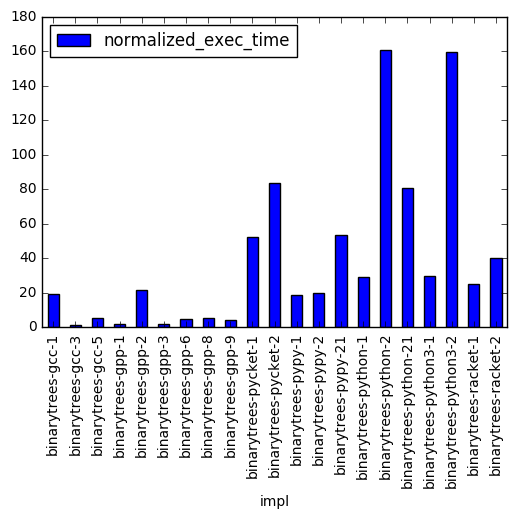

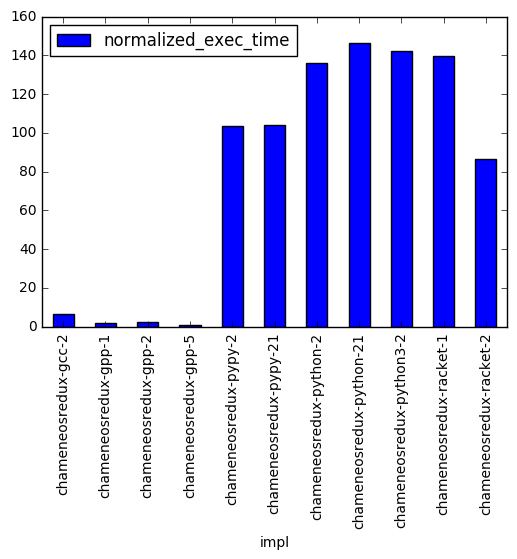

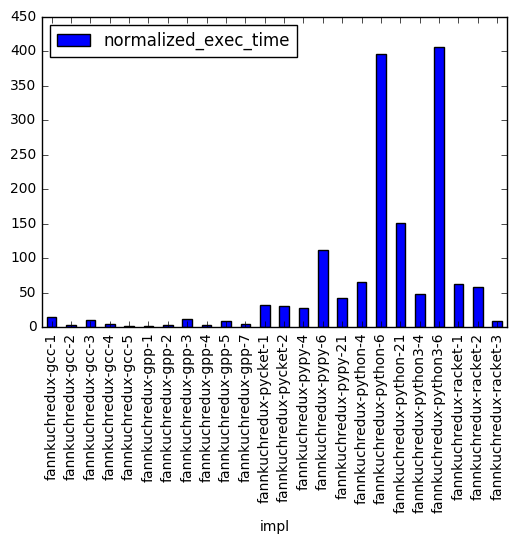

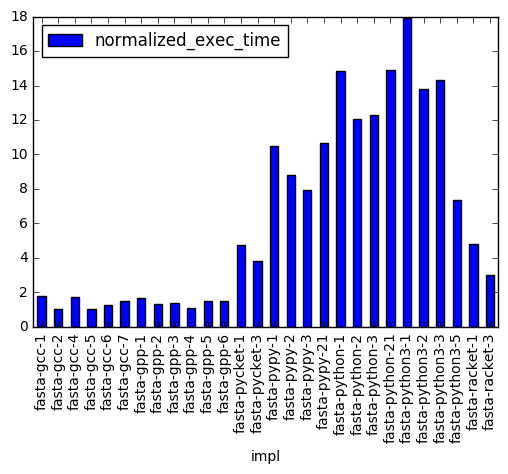

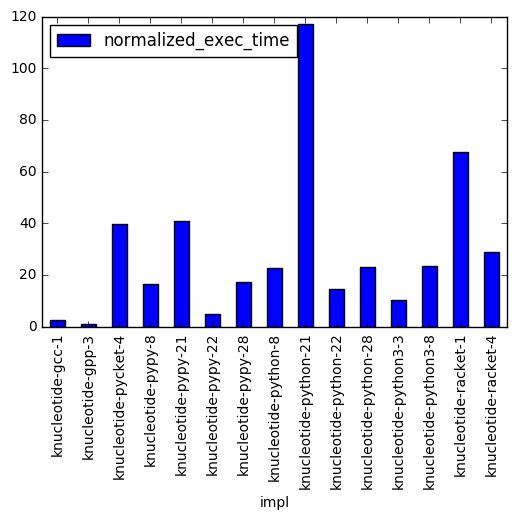

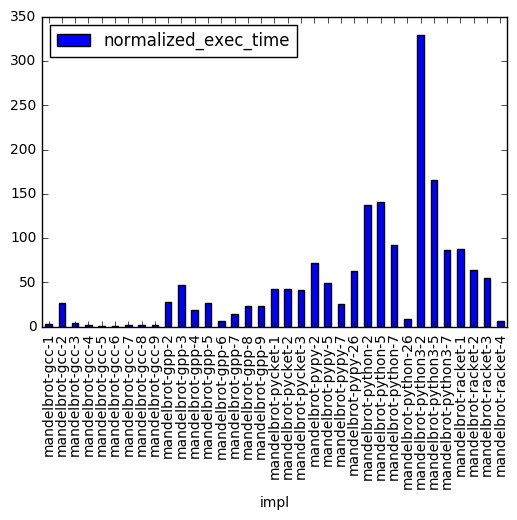

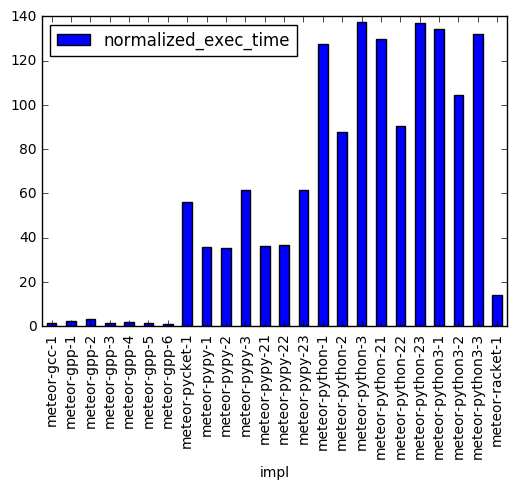

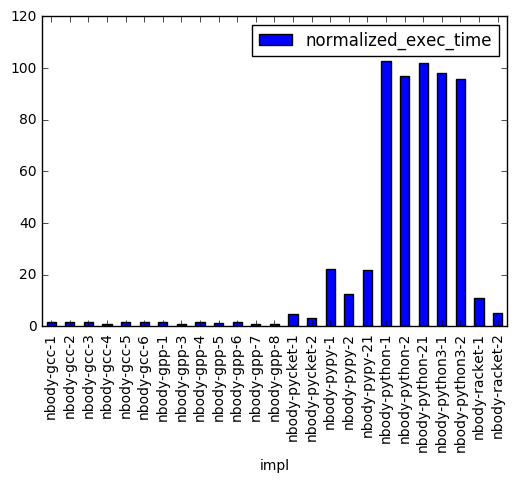

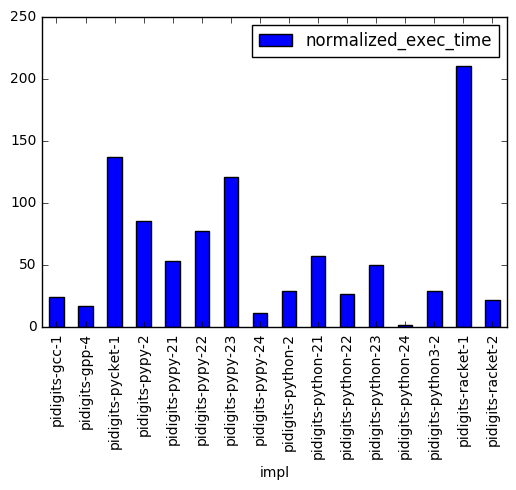

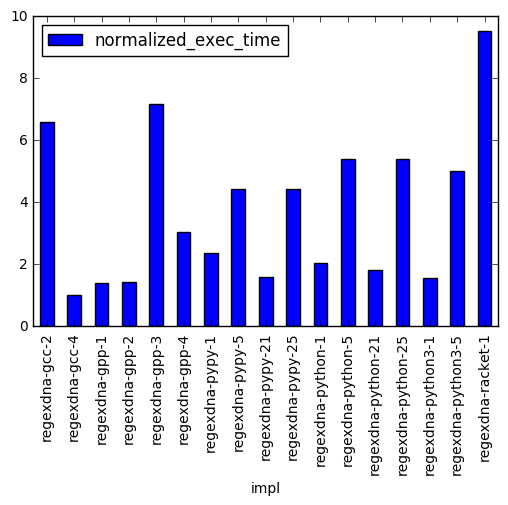

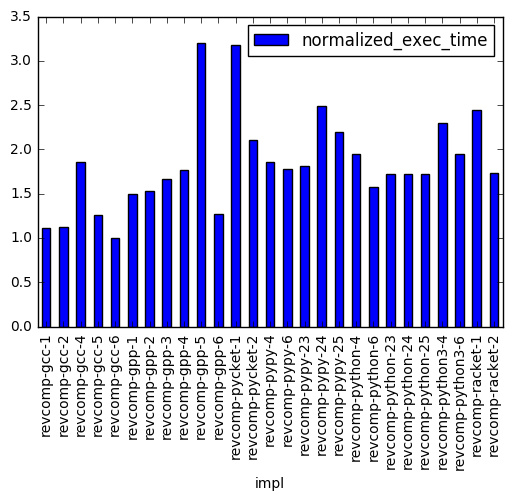

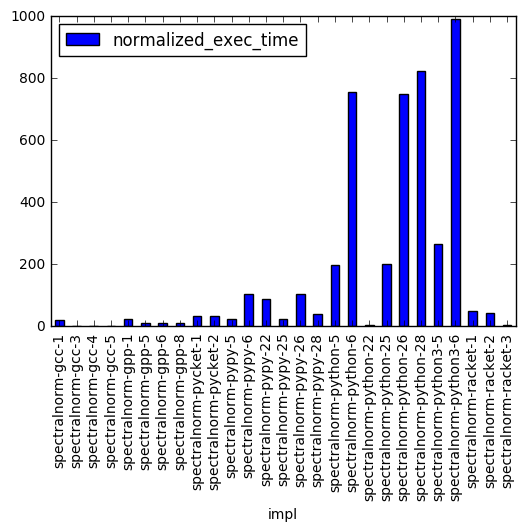

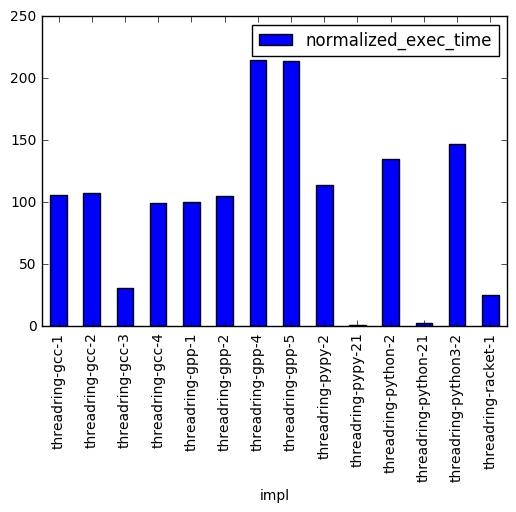

In [83]:
for bmark in bmarks:
    df[df["name"] == bmark].plot( kind="bar", x="impl", y="normalized_exec_time" )

## Python 2 vs Python 3

In [98]:
# Create a df with fastest impl first by lang, then bmark.
fast_lang = df.sort_values( by="elapsed(s)" ).groupby( [ "lang", "name" ] ).first()

In [99]:
# For example, get fastest python impl of binarytrees:
fast_lang.loc["python"].loc["binarytrees"]

id                                         1
n                                         20
size(B)                                  708
cpu(s)                               224.478
mem(KB)                                    0
status                                     0
load                                       %
elapsed(s)                            20.006
impl                    binarytrees-python-1
normalized_exec_time                 29.0785
Name: binarytrees, dtype: object

In [100]:
fast_lang.loc["python"]

,id,n,size(B),cpu(s),mem(KB),status,load,elapsed(s),impl,normalized_exec_time
name,,,,,,,,,,
binarytrees,1,20,708,224.478,0,0,%,20.006,binarytrees-python-1,29.078488
chameneosredux,2,6000000,1192,0.000,0,-10,%,189.341,chameneosredux-python-2,135.923187
fannkuchredux,4,12,1261,4500.314,0,0,%,289.917,fannkuchredux-python-4,65.281918
fasta,2,25000000,1917,93.207,0,0,%,94.389,fasta-python-2,12.051711
knucleotide,22,25000000,801,61.647,0,0,%,36.012,knucleotide-python-22,14.550303
mandelbrot,26,16000,3832,154.309,0,0,%,10.969,mandelbrot-python-26,9.163743
meteor,2,2098,1487,4.895,0,0,%,4.921,meteor-python-2,87.875000
nbody,2,50000000,1392,733.400,0,0,%,733.587,nbody-python-2,96.817606
pidigits,24,10000,378,0.038,0,0,%,0.092,pidigits-python-24,1.000000


In [101]:
fast_lang.loc["python3"]

,id,n,size(B),cpu(s),mem(KB),status,load,elapsed(s),impl,normalized_exec_time
name,,,,,,,,,,
binarytrees,1,20,708,226.761,0,0,%,20.231,binarytrees-python3-1,29.405523
chameneosredux,2,6000000,1191,356.381,0,0,%,197.977,chameneosredux-python3-2,142.122757
fannkuchredux,4,12,1069,3282.465,0,0,%,211.979,fannkuchredux-python3-4,47.732268
fasta,5,25000000,2016,130.026,0,0,%,57.543,fasta-python3-5,7.347165
knucleotide,3,25000000,2011,377.699,0,0,%,25.462,knucleotide-python3-3,10.287677
mandelbrot,7,16000,759,1651.484,0,0,%,104.252,mandelbrot-python3-7,87.094403
meteor,2,2098,1463,5.824,0,0,%,5.842,meteor-python3-2,104.321429
nbody,2,50000000,1392,726.453,0,0,%,726.624,nbody-python3-2,95.898641
pidigits,2,10000,493,2.582,0,0,%,2.612,pidigits-python3-2,28.391304


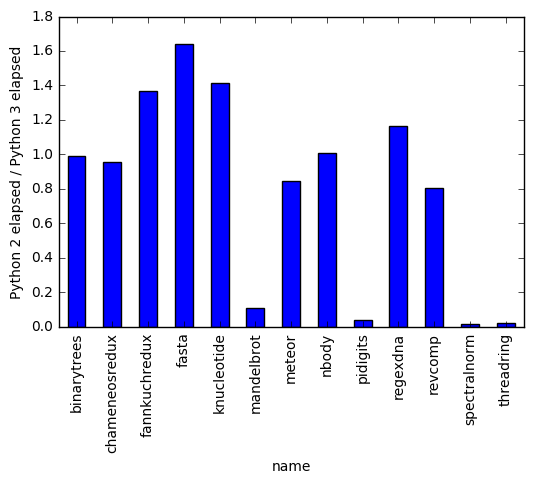

In [115]:
# Plot fastest python and python3.
ax = (fast_lang.loc["python"]["elapsed(s)"] / fast_lang.loc["python3"]["elapsed(s)"]).plot( kind="bar" )
ax.set_ylabel("Python 2 elapsed / Python 3 elapsed")

In [123]:
# Merge python and python3 matching name and id.
py23_df = df[df.lang == "python"].merge( df[df.lang == "python3" ], on=["name", "id"] )

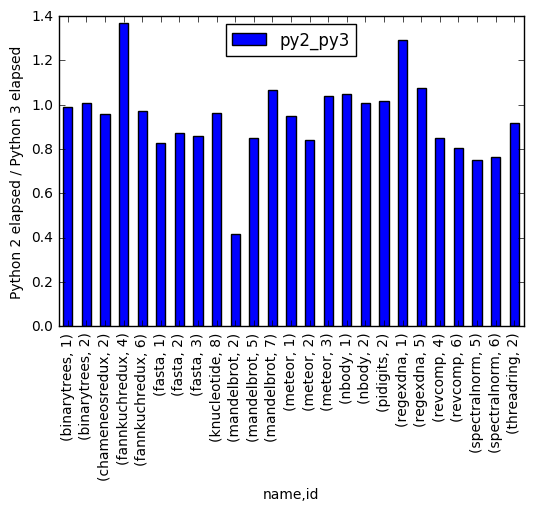

In [126]:
# Generate a new field py2_py3 that divides the elapsed times from merged cols.
ax = py23_df.assign( py2_py3=py23_df["elapsed(s)_x"] / py23_df["elapsed(s)_y"]) \
            .plot( kind="bar", x=["name","id"], y="py2_py3")
ax.set_ylabel("Python 2 elapsed / Python 3 elapsed")

## PyPy vs CPython 2

In [127]:
pypy_df = df[df.lang == "pypy"].merge( df[df.lang == "python" ], on=["name", "id"] )

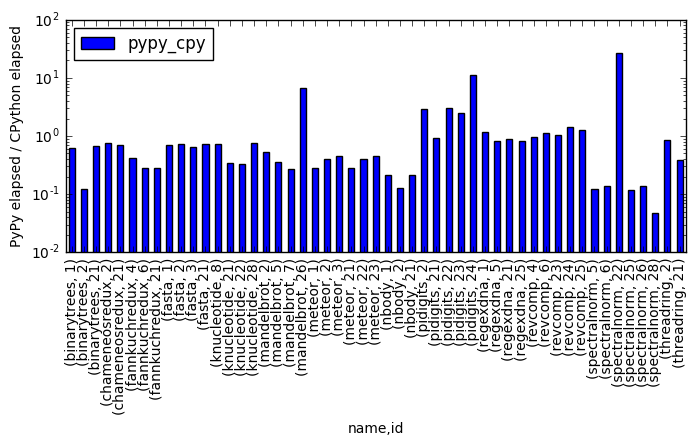

In [133]:
ax = pypy_df.assign( pypy_cpy=pypy_df["elapsed(s)_x"] / pypy_df["elapsed(s)_y"]) \
            .plot( kind="bar", x=["name","id"], y="pypy_cpy", figsize=(8,3), logy=True )
ax.set_ylabel("PyPy elapsed / CPython elapsed")

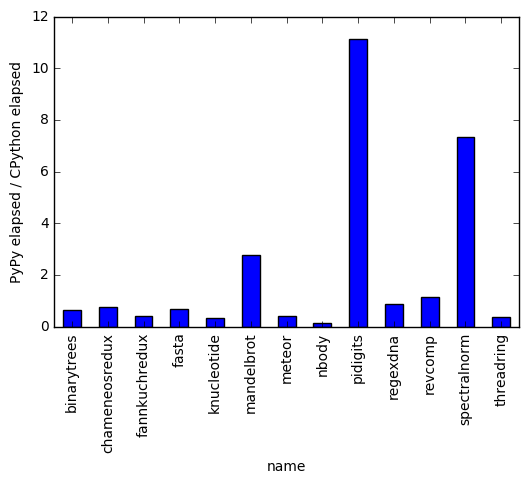

In [134]:
# Plot fastest python and python3.
ax = (fast_lang.loc["pypy"]["elapsed(s)"] / fast_lang.loc["python"]["elapsed(s)"]).plot( kind="bar" )
ax.set_ylabel("PyPy elapsed / CPython elapsed")

/research/brg/install/venv-pkgs/x86_64-centos6/python2.7.12/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


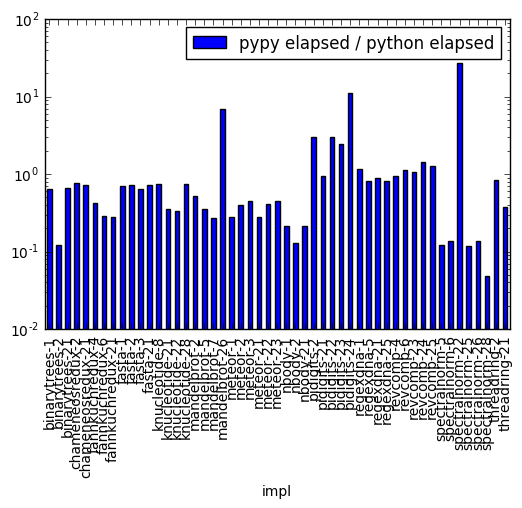

In [19]:
pypycpy_df = gen_comp_df("python", "pypy")
pypycpy_df.plot(kind="bar", x="impl", y="pypy elapsed / python elapsed", logy=True)

## Pycket vs Racket

/research/brg/install/venv-pkgs/x86_64-centos6/python2.7.12/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


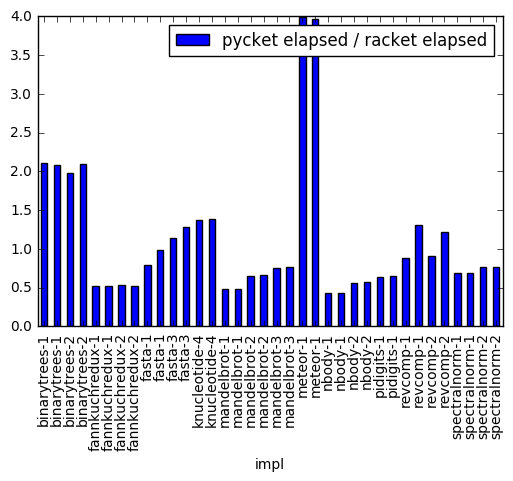

In [20]:
pycketracket_df = gen_comp_df("racket", "pycket")
pycketracket_df.plot(kind="bar", x="impl", y="pycket elapsed / racket elapsed" )

## Fastest implementations in each language